# Frame the Problem

### Story
The United Kingdom government wants to devote a large portion of funding towards suprressing vehicular accidents. Before they go through with this proposed funding, they want to identify trends in the accident reports to find spots of high accidental occurence. The funding will be used to fix the roads and/or create new, safer road designs.

1. Define the objective in business terms. 
    - Utilizing the United Kingdom vehicle related accidents dataset, we want to identify causes of accidents for different areas in the UK and determine what spots should the funding be focused to.
2. How will your solution be used? 
    - Hopefully, by figuring out the locations of high accidents and also determine their causes, we will able to rationalize the funding.
3. What are the current solutions/workarounds (if any)? 
    - None
4. How should you frame this problem (supervised/unsupervised, online/offline, ...)? 
    - This will be a supervised, classification offline learning problem.
5. How should performance be measured? Is the performance measure aligned with the business objective?
    - To not waste fundings, we would want to be as accurate as possible as this proposal was created in the intent to save lives. Therefore we would want to use precision.
6. What would be the minimum performance needed to reach the business objective? 
    - Because we want to be extremely accurate, we want to aim for the best performance possible. Based on the score will determine whether or not the funding should be dispersed.
7. What are comparable problems? Can you reuse experience or tools?
    - A similar problem would be the bike sharing problem where there was a similar design in the "hot spots" and it being a supervised classification itself.
8. Is human expertise available?
    - No
9. How would you solve the problem manually?
    - I would try and find trends of accidents at specific spots. Perhaps this spot at this time is more prone to there being accidents, maybe this spot has a bad blind spot for vehicles causing more civilian death. I would leave out consumer related information such as the type of vehicles, however still would check to see if specific cause more accidents at certain spots (maybe super cars on highways?). I would also try and see trends in the person information, perhaps deduce whether new laws should be constructed for older drivers to be reexamined. I would also leave out unnecessary data like resulting police force.
10.  List the assumptions you (or others) have made so far. Verify assumptions if possible.
    - I assume that weather would be a cause for higher deaths and also time frames for rush hour. I also assume living types such as rural vs city would be much different. Highways would have much more severe accidents.



In [3]:
import numpy as np
import scipy.sparse
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MultiLabelBinarizer, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [4]:
def load_data():
    """
    Loads the data from the CSV files.
    """
    
    accidents = pd.read_csv('Accidents0514.csv')
    casualties = pd.read_csv('Casualties0514.csv')
    vehicles = pd.read_csv('Vehicles0514.csv')
    return accidents, casualties, vehicles

In [5]:
accidents, casualties, vehicles = load_data()

/var/folders/ns/jhsc1w3d101cp62xgg0jvvg00000gn/T/ipykernel_5341/3544293404.py:1: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  accidents, casualties, vehicles = load_data()


In [6]:
accidents

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,1,2,1,1,04/01/2005,...,0,1,1,2,2,0,0,1,1,E01002849
1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,1,3,1,1,05/01/2005,...,0,5,4,1,1,0,0,1,1,E01002909
2,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1,3,2,1,06/01/2005,...,0,0,4,1,1,0,0,1,1,E01002857
3,200501BS00004,526900.0,177530.0,-0.173862,51.482442,1,3,1,1,07/01/2005,...,0,0,1,1,1,0,0,1,1,E01002840
4,200501BS00005,528060.0,179040.0,-0.156618,51.495752,1,3,1,1,10/01/2005,...,0,0,7,1,2,0,0,1,1,E01002863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640592,2014984136414,310037.0,597647.0,-3.417278,55.264773,98,2,2,1,07/12/2014,...,0,0,6,3,3,0,0,2,1,NaN
1640593,2014984137514,321509.0,574063.0,-3.230255,55.054855,98,3,2,2,11/12/2014,...,0,0,6,1,3,0,0,2,1,NaN
1640594,2014984137714,321337.0,566365.0,-3.230826,54.985668,98,3,1,1,09/12/2014,...,0,0,4,1,4,0,0,2,1,NaN
1640595,2014984138414,323869.0,566853.0,-3.191397,54.990446,98,2,3,2,17/12/2014,...,0,0,6,2,2,0,0,2,1,NaN


In [7]:
casualties

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type
0,200501BS00001,1,1,3,1,37,7,2,1,1,0,0,-1,0,1
1,200501BS00002,1,1,2,1,37,7,3,0,0,0,4,-1,11,1
2,200501BS00003,2,1,1,1,62,9,3,0,0,0,0,-1,9,1
3,200501BS00004,1,1,3,1,30,6,3,5,2,0,0,-1,0,1
4,200501BS00005,1,1,1,1,49,8,3,0,0,0,0,-1,3,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2216715,2014984137714,1,1,2,2,16,4,3,0,0,2,0,0,9,1
2216716,2014984138414,1,1,1,1,27,6,3,0,0,0,0,0,9,1
2216717,2014984138414,2,2,1,1,44,7,2,0,0,0,0,0,19,1
2216718,2014984139614,1,2,2,1,61,9,3,0,0,0,4,0,11,2


In [8]:
vehicles

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type
0,200501BS00001,1,9,0,18,0,0,0,0,0,...,1,15,2,74,10,-1,-1,-1,7,1
1,200501BS00002,1,11,0,4,0,3,0,0,0,...,1,1,1,42,7,8268,2,3,-1,-1
2,200501BS00003,1,11,0,17,0,0,0,4,0,...,1,1,1,35,6,8300,2,5,2,1
3,200501BS00003,2,9,0,2,0,0,0,0,0,...,1,15,1,62,9,1762,1,6,1,1
4,200501BS00004,1,9,0,18,0,0,0,0,0,...,1,15,2,49,8,1769,1,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004420,2014984138414,1,9,0,5,0,6,0,0,0,...,1,2,1,27,6,1781,1,12,6,1
3004421,2014984138414,2,19,0,18,0,1,1,4,7,...,1,2,1,44,7,1686,2,4,1,1
3004422,2014984138414,3,9,0,18,0,2,1,4,1,...,1,6,1,73,10,2143,2,-1,8,3
3004423,2014984139614,1,11,0,9,0,8,0,0,0,...,1,1,1,40,7,4500,2,4,-1,3


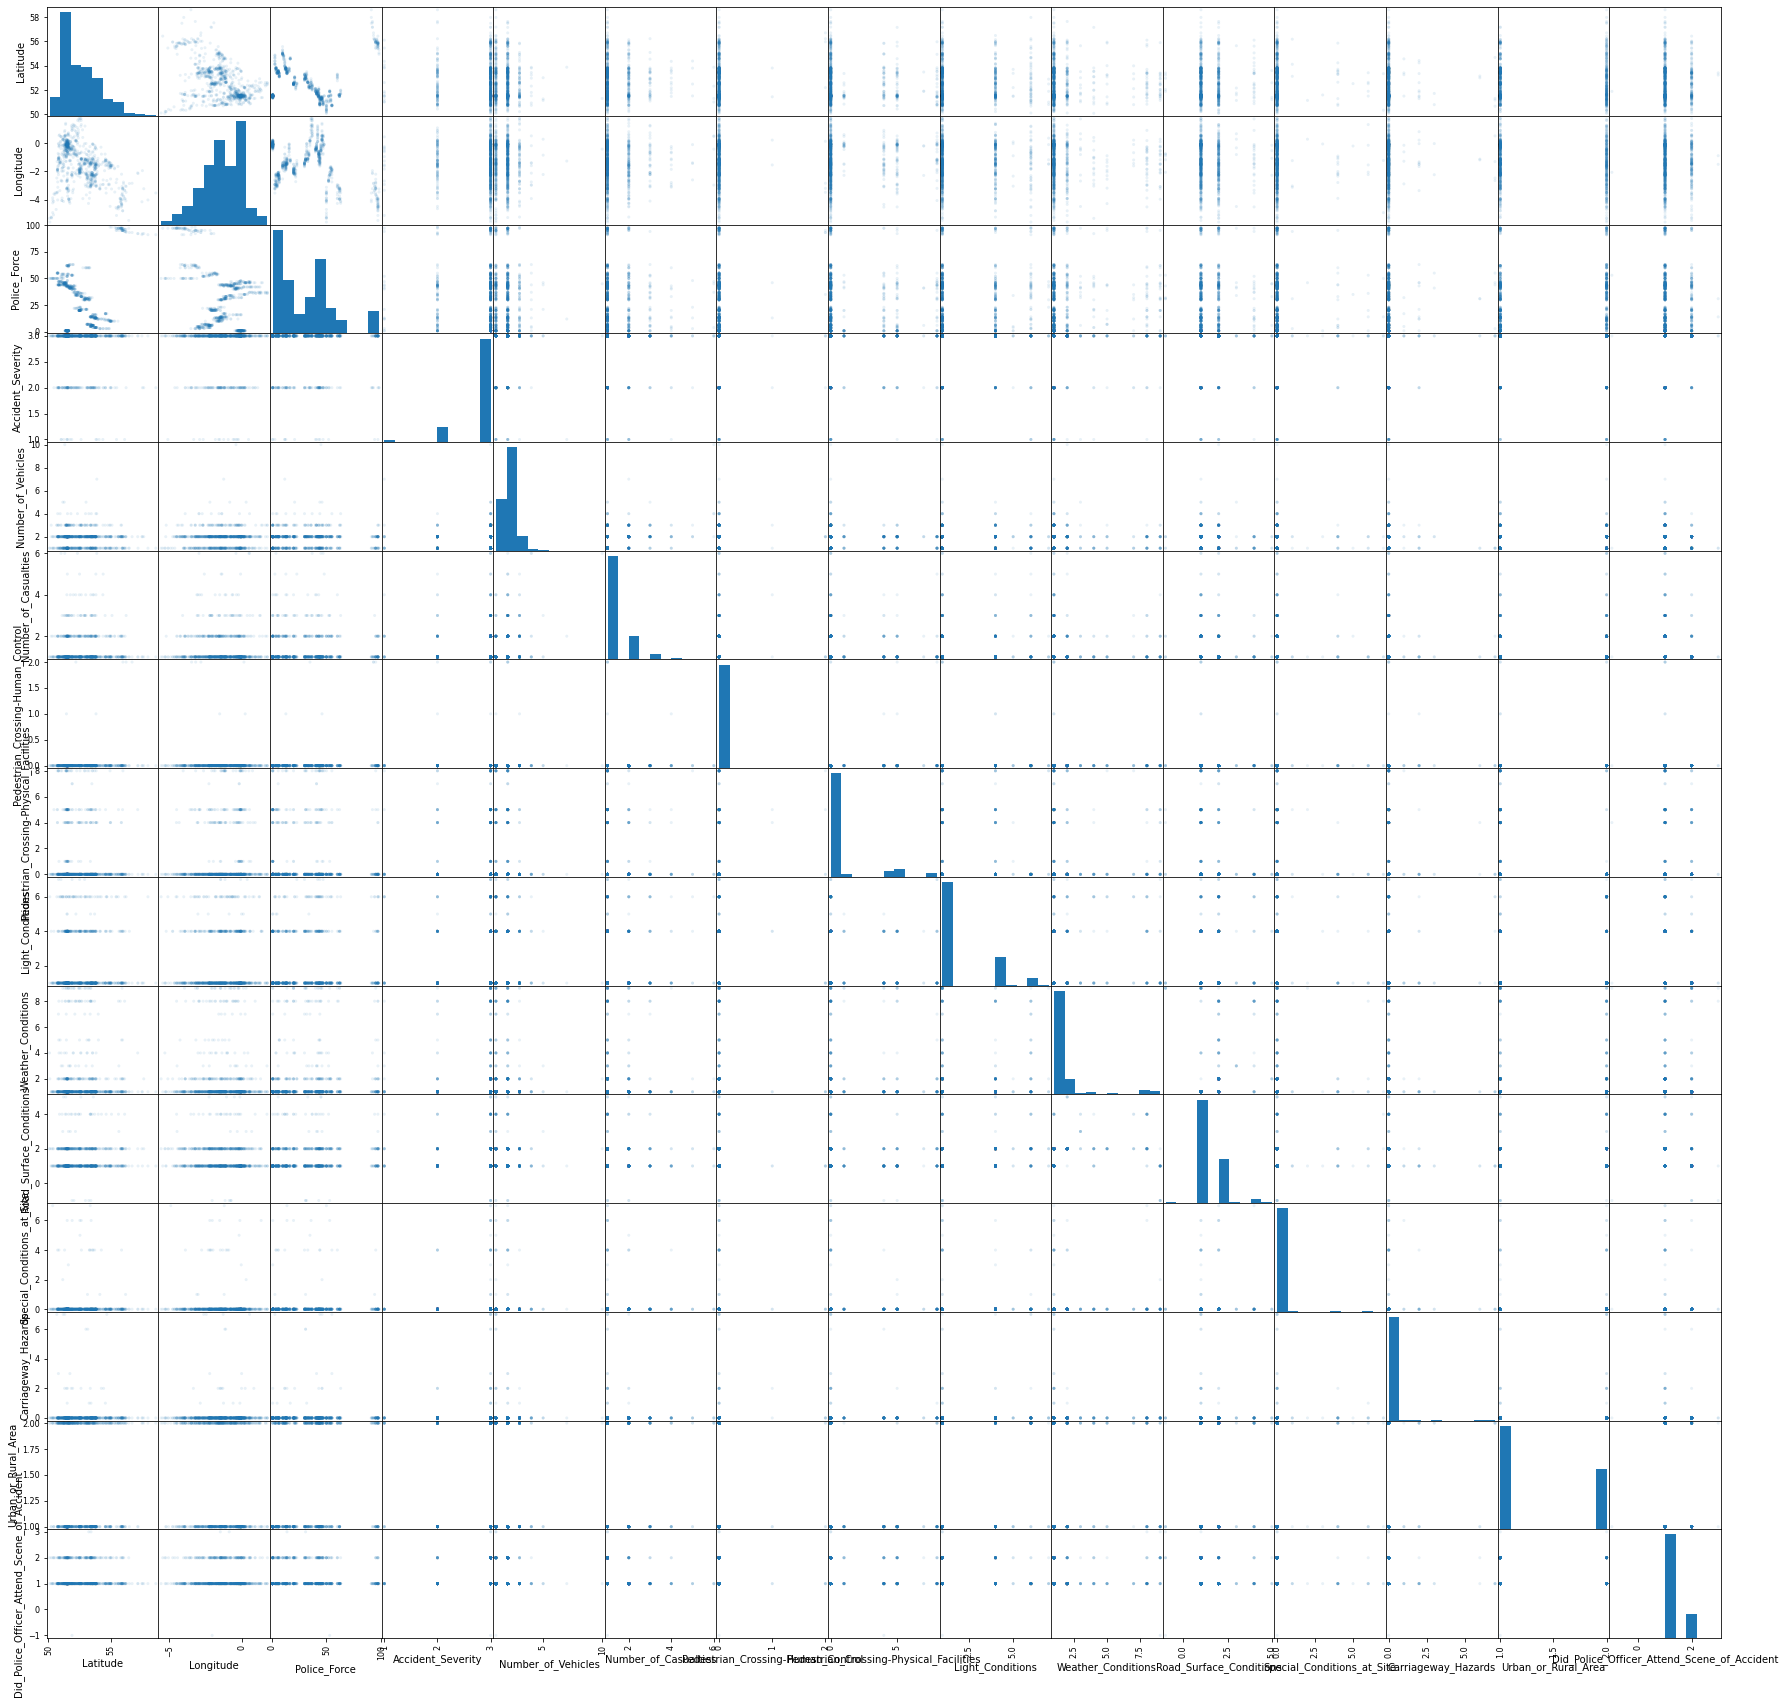

In [17]:
accident_related = accidents[['Latitude', 'Longitude', 'Police_Force', 'Accident_Severity',	'Number_of_Vehicles', 'Number_of_Casualties', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident']]
accident_samples = accident_related.sample(n=1000)
pd.plotting.scatter_matrix(accident_samples, alpha=0.1, figsize=(30,30));

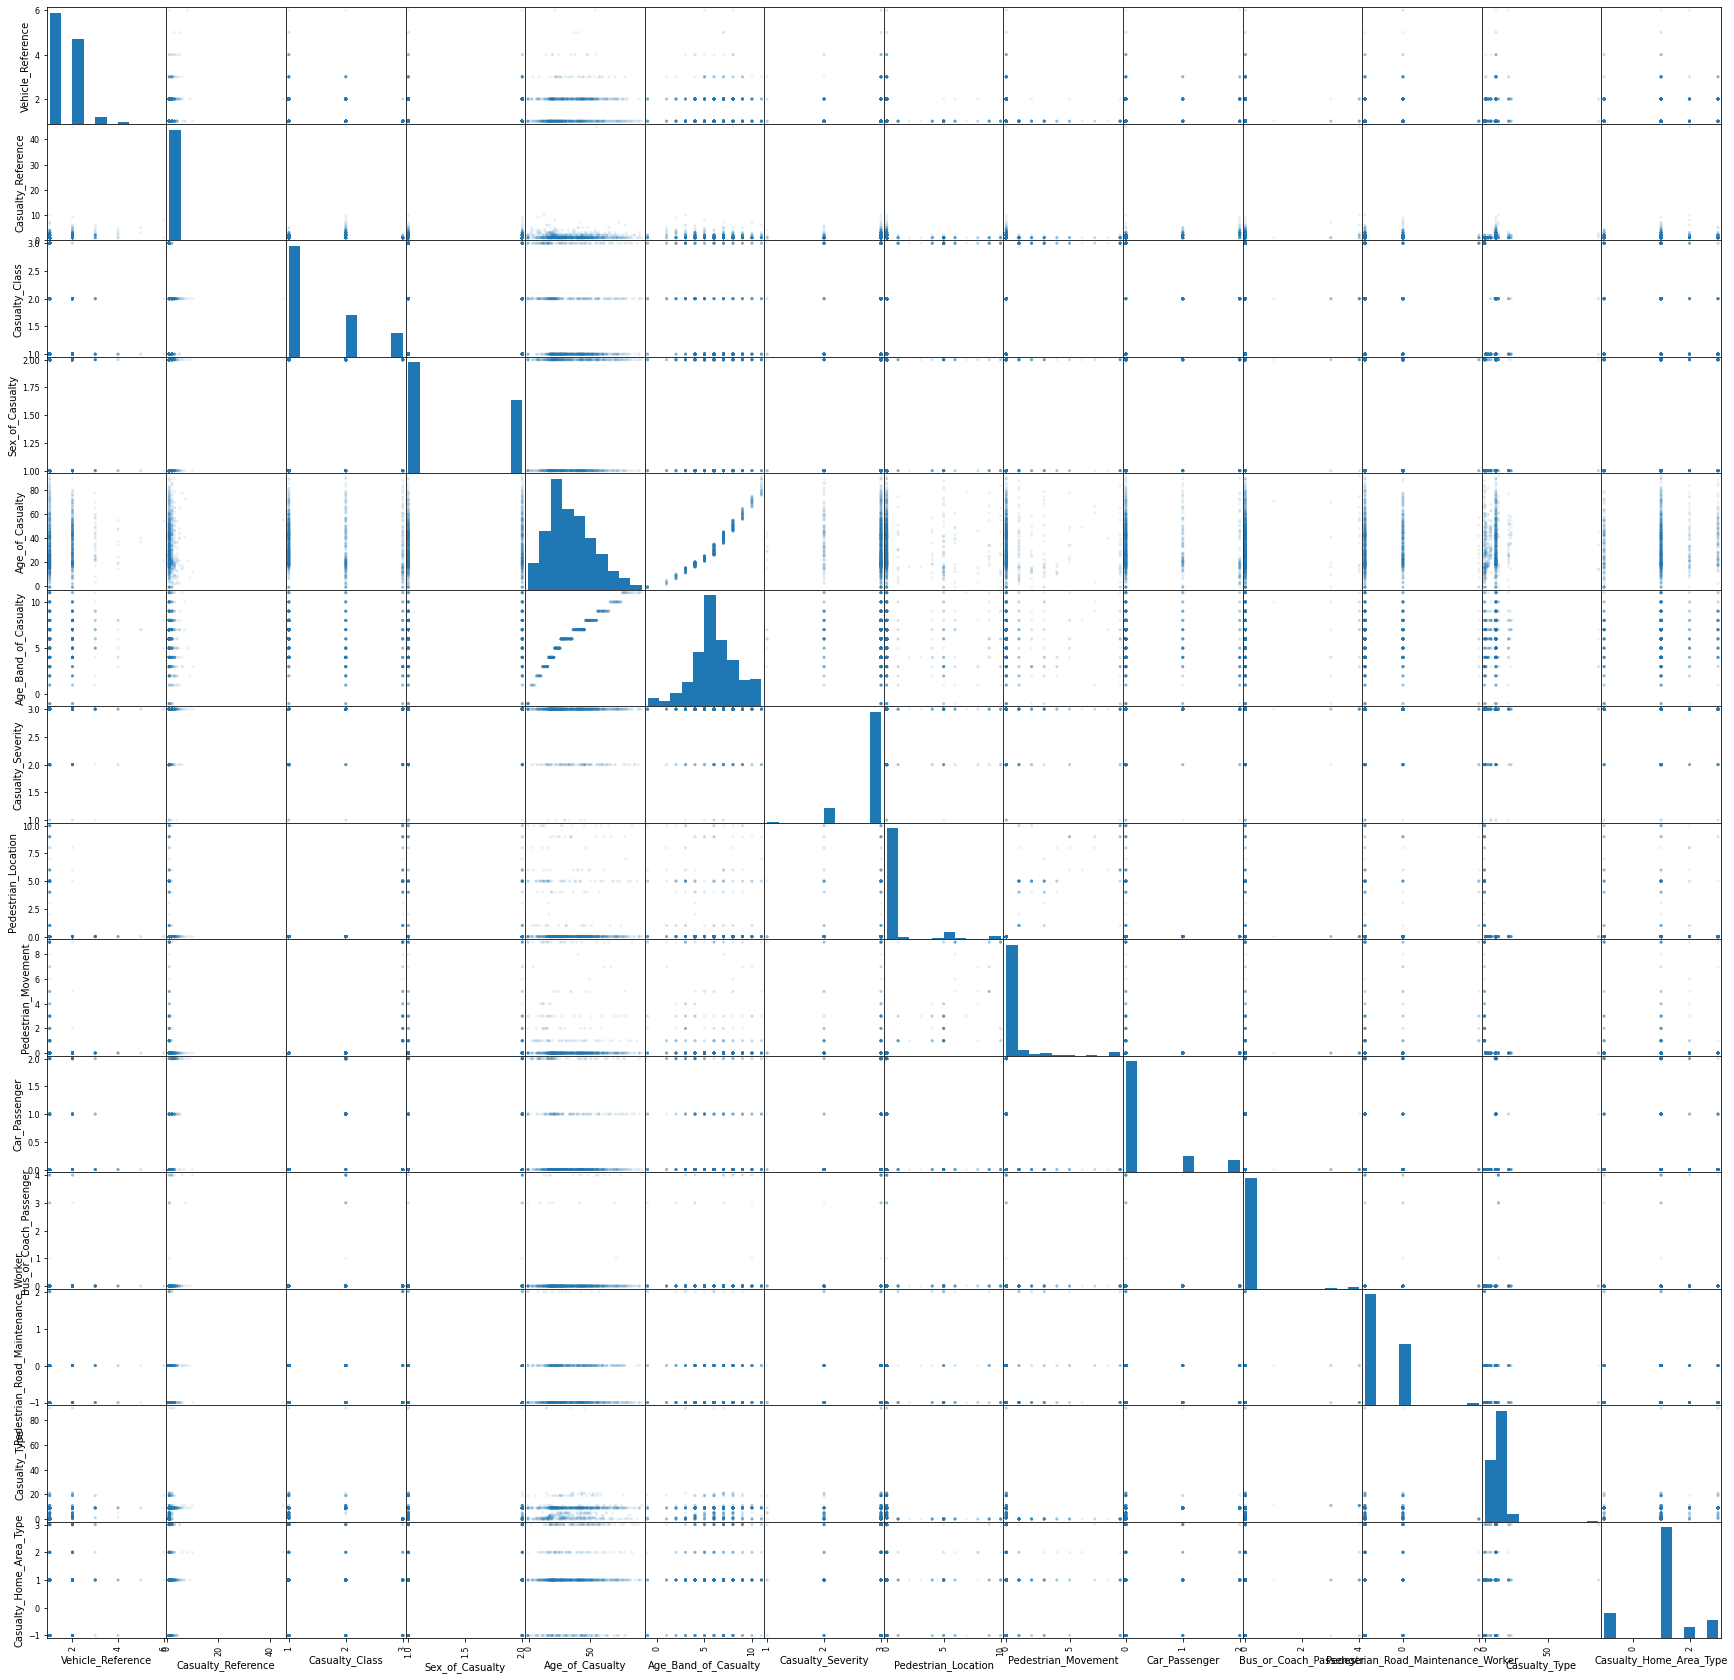

In [18]:
casualty_related = casualties.drop(['Accident_Index'], axis=1)
casualty_samples = casualty_related.sample(n=1000)
pd.plotting.scatter_matrix(casualty_samples, alpha=0.1, figsize=(30,30));

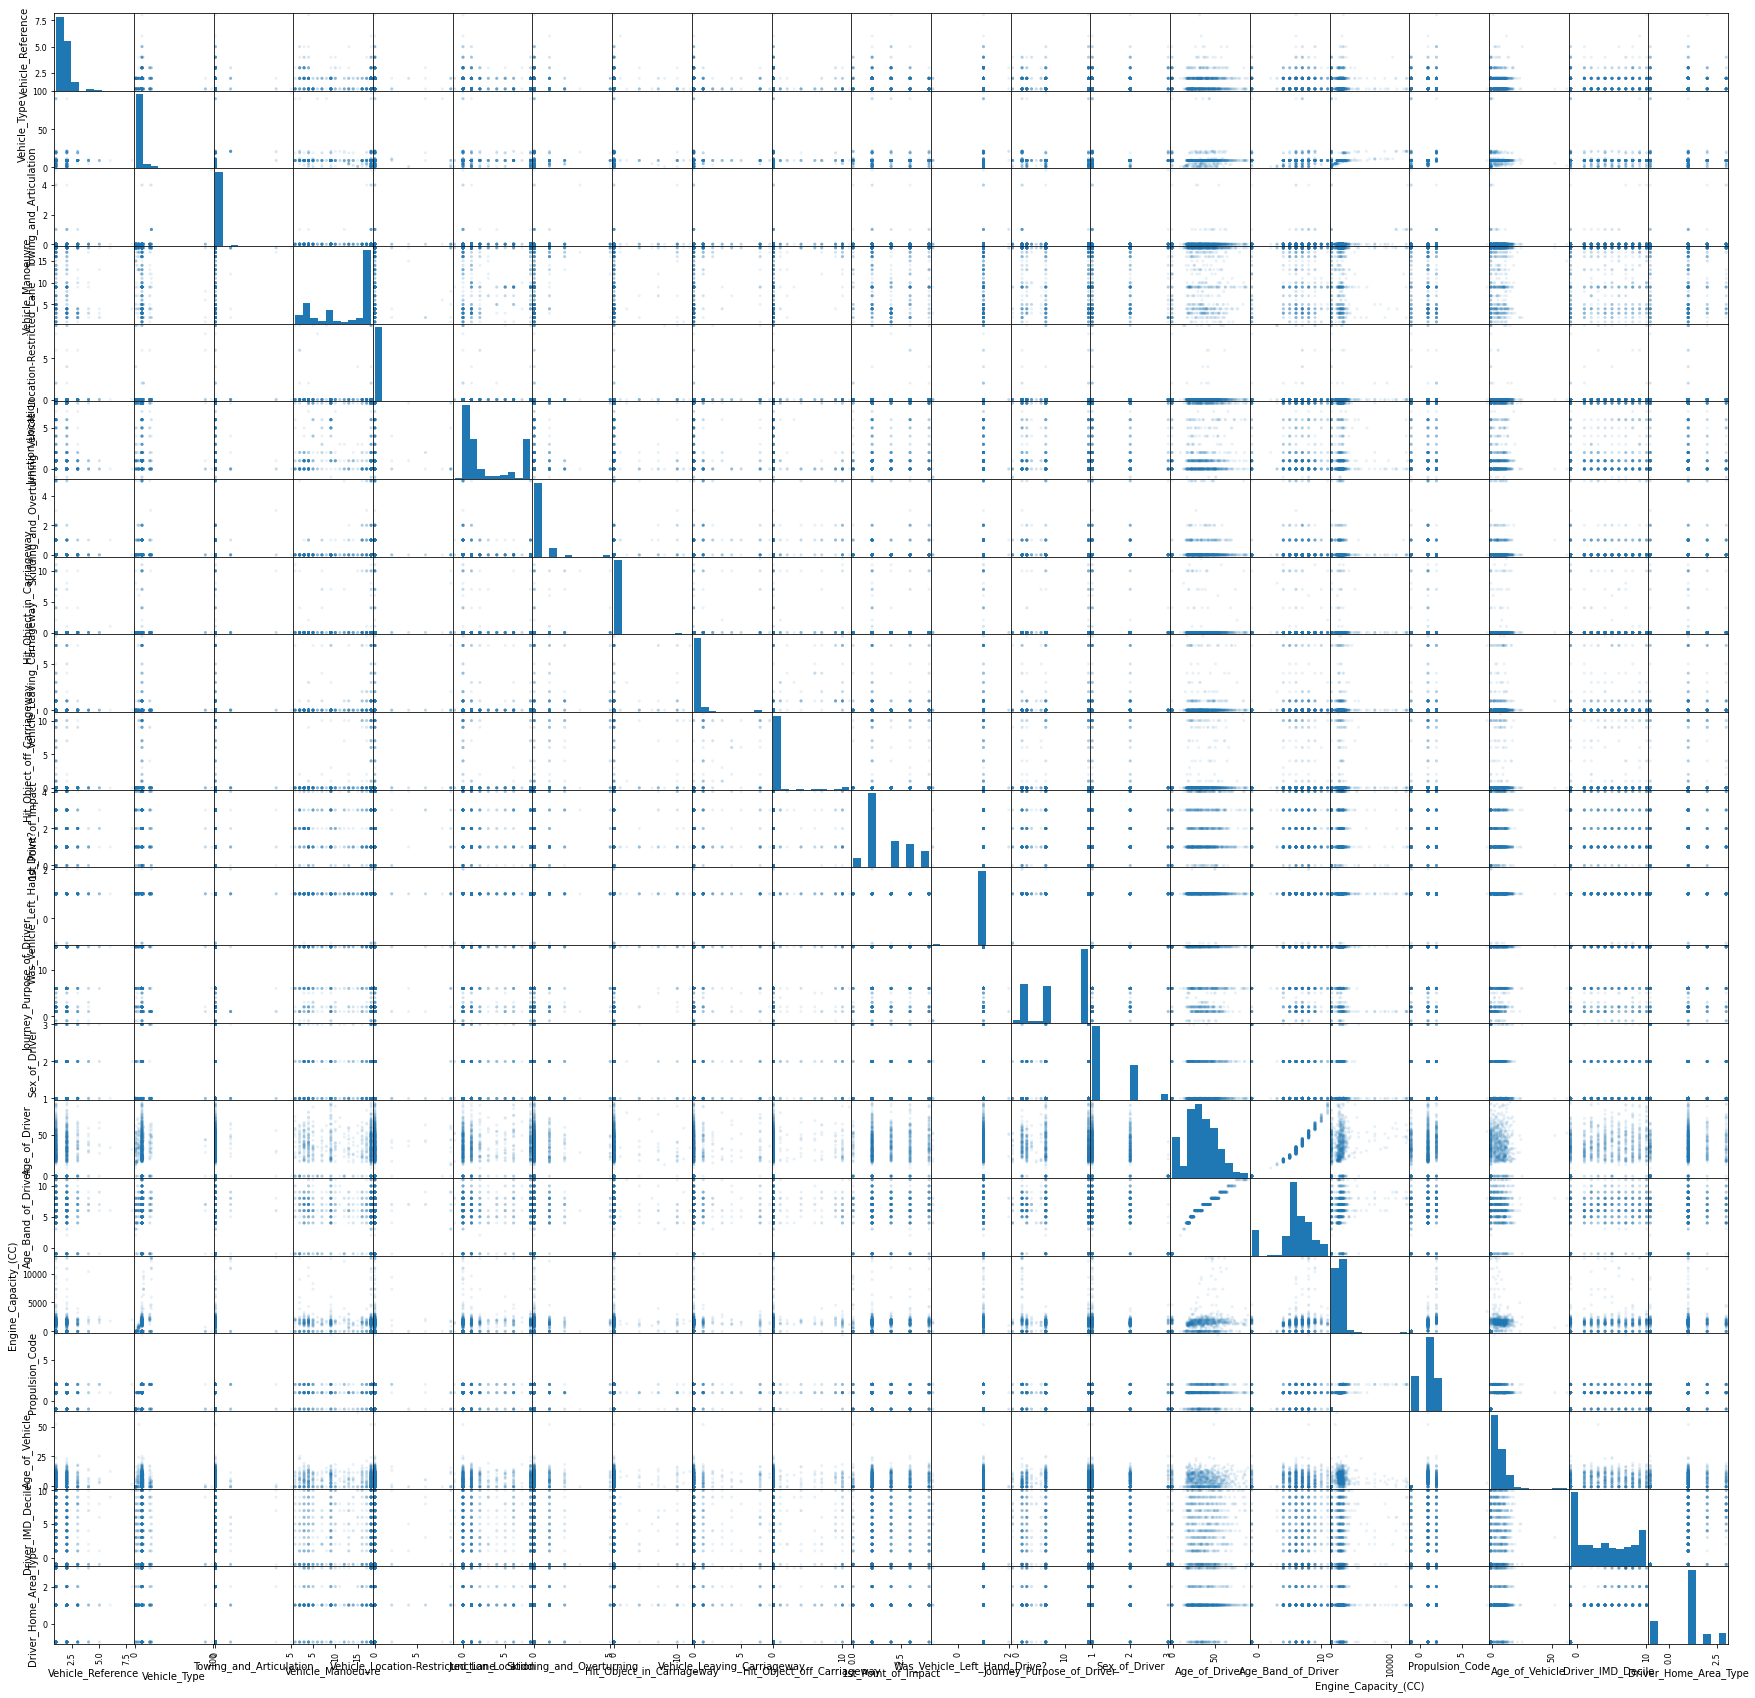

In [19]:
vehicle_related = vehicles.drop(['Accident_Index'], axis=1)
vehicle_samples = vehicle_related.sample(n=1000)
pd.plotting.scatter_matrix(vehicle_samples, alpha=0.1, figsize=(30,30));

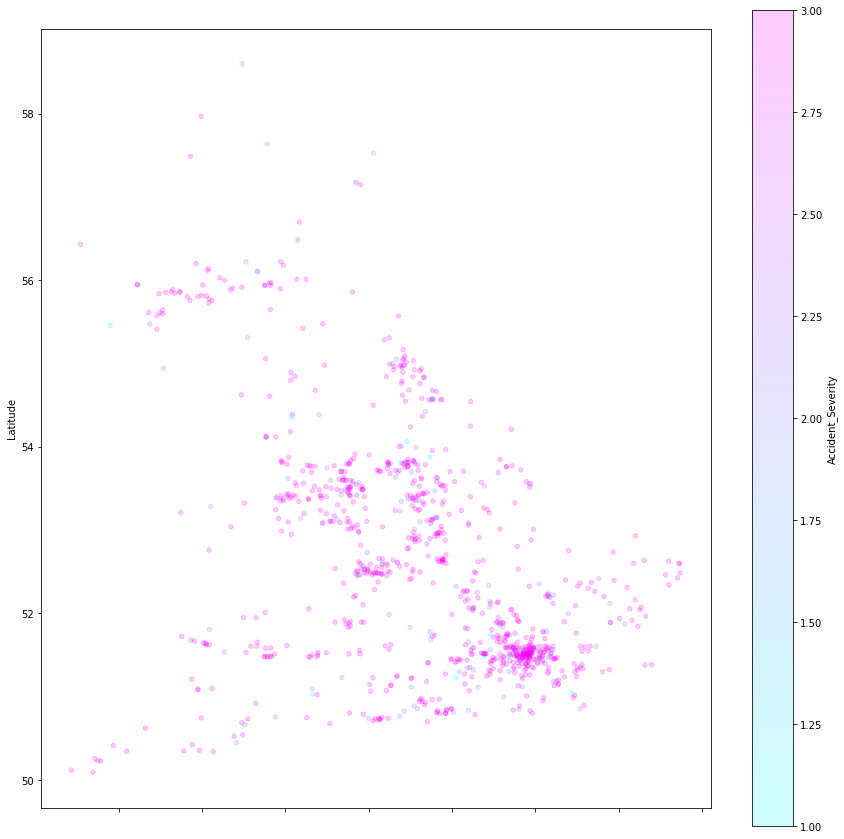

In [54]:
# View the geographical data based on accident severity
accident_samples.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.2, c='Accident_Severity' , cmap='cool', figsize=(15,15));
plt.gca().set_aspect('equal')

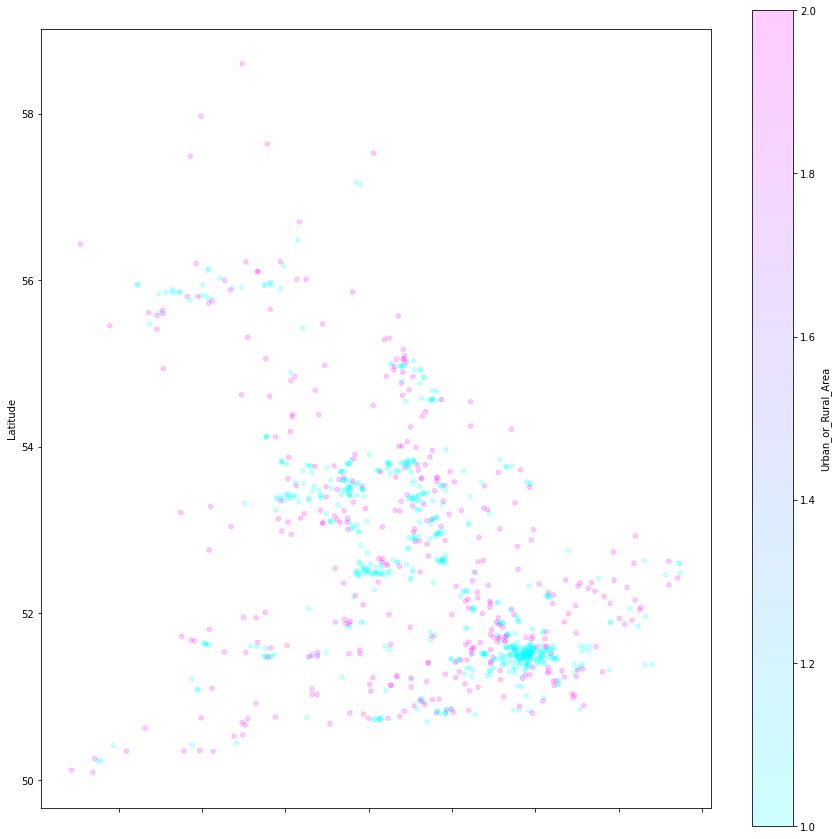

In [56]:
# View the geographical data based on Area of the accident
accident_samples.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.2, c='Urban_or_Rural_Area' , cmap='cool', figsize=(15,15));
plt.gca().set_aspect('equal')

In [57]:
sns.heatmap(accident_samples.corrwith(casualty_samples), annot=True)

IndexError: Inconsistent shape between the condition and the input (got (29, 1) and (29,))